In [1]:
# you need the nok.xml file to run this


In [2]:
from datetime import datetime
import xml.etree.ElementTree as ET

tree = ET.parse('nok.xml')
root = tree.getroot()

nok_eur_dict = {}

node = root
for child in node:
    if "DataSet" in child.tag:
        node = child
        for child in node:
            if "Series" in child.tag:
                node = child
                for child in node:
                    if "Obs" in child.tag:
                        node = child
                        # print(node.attrib["TIME_PERIOD"], node.attrib["OBS_VALUE"], sep="\t")
                        nok_eur_dict[datetime.strptime(node.attrib["TIME_PERIOD"], \
                                                       "%Y-%m-%d")] = float(node.attrib["OBS_VALUE"])


In [3]:
import math

num_entries = 256

dates = sorted(nok_eur_dict.keys())[len(nok_eur_dict) - num_entries:]

t_values = []
d_values = []

t_prev = -1
for date in dates:
    t_relative = (date - dates[0]).days
    for i in range(t_relative - t_prev):
        t_values.append(t_relative)
        d_values.append(math.log(nok_eur_dict[date]))
        print(t_relative, nok_eur_dict[date], math.log(nok_eur_dict[date]), sep = "\t")
    t_prev = t_relative

0	9.64	2.265921108622454
1	9.667	2.268718023482468
4	9.7675	2.2790605479470885
4	9.7675	2.2790605479470885
4	9.7675	2.2790605479470885
5	9.7553	2.277810727061961
6	9.9388	2.2964462890346358
7	10.013	2.303884248725666
8	10.0035	2.3029350317583335
11	9.9188	2.2944319462376583
11	9.9188	2.2944319462376583
11	9.9188	2.2944319462376583
12	9.8945	2.2919790472068216
13	9.9483	2.297401682301891
14	10.0615	2.308716258924286
15	9.9836	2.30094374672192
18	9.9718	2.2997611093029438
18	9.9718	2.2997611093029438
18	9.9718	2.2997611093029438
19	9.9988	2.3024650857934694
20	10.1125	2.31377228238461
21	10.1203	2.3145433076887114
22	10.1985	2.322240650652487
25	10.2826	2.3304531463365183
25	10.2826	2.3304531463365183
25	10.2826	2.3304531463365183
26	10.273	2.3295190942341266
27	10.2858	2.3307643032593535
28	10.235	2.325813219113253
29	10.2335	2.325666652437367
32	10.3585	2.3378074387038064
32	10.3585	2.3378074387038064
32	10.3585	2.3378074387038064
33	10.3473	2.336725616113777
34	10.4576	2.3473289868034

In [4]:
import numpy as np
import statsmodels.api as sm

t_dat_stable = np.asarray(t_values)
d_dat_stable = np.asarray(d_values)

linear_fit_d = sm.OLS(np.asarray(d_dat_stable), sm.add_constant(np.asarray(t_dat_stable))).fit()

print("Fit:\n", linear_fit_d.summary())
print("\nFit params:", linear_fit_d.params, end="\n")

residual = [d_dat_stable[i] - (linear_fit_d.params[0] + linear_fit_d.params[1]*t_dat_stable[i]) for i in range(t_dat_stable.size)]

Fit:
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     1465.
Date:                Wed, 23 Aug 2023   Prob (F-statistic):          2.65e-129
Time:                        22:15:45   Log-Likelihood:                 844.66
No. Observations:                 364   AIC:                            -1685.
Df Residuals:                     362   BIC:                            -1678.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3107      0.002    925.049   

<AxesSubplot:xlabel='t, i.e., whole days from a selected starting point', ylabel='d, i.e., ln(EUR:NOK)'>

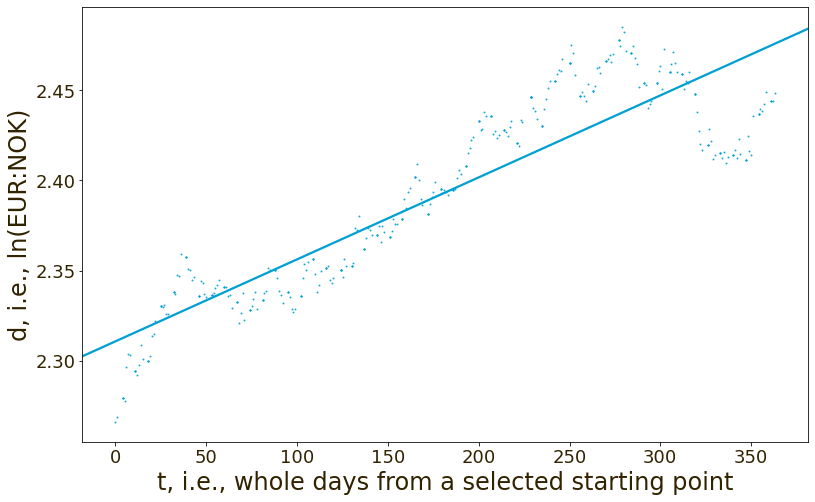

In [5]:
import seaborn as sbn
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
plt.xticks(fontsize=18, color="#322300")
plt.yticks(fontsize=18, color="#322300")
ax.set_xlabel("t, i.e., whole days from a selected starting point", fontsize=24, color="#322300")
ax.set_ylabel("d, i.e., ln(EUR:NOK)", fontsize=24, color="#322300")

sbn.regplot(x=t_dat_stable, y=d_dat_stable, color='#00a0d2', order=1, \
            scatter_kws={'s':1}, ci=None, truncate=False)

# sbn.regplot(x=t_dat_stable, y=residual, color='#147864', order=1, \
#             scatter_kws={'s':1}, ci=None, truncate=False)

<AxesSubplot:xlabel='t', ylabel='residual of d'>

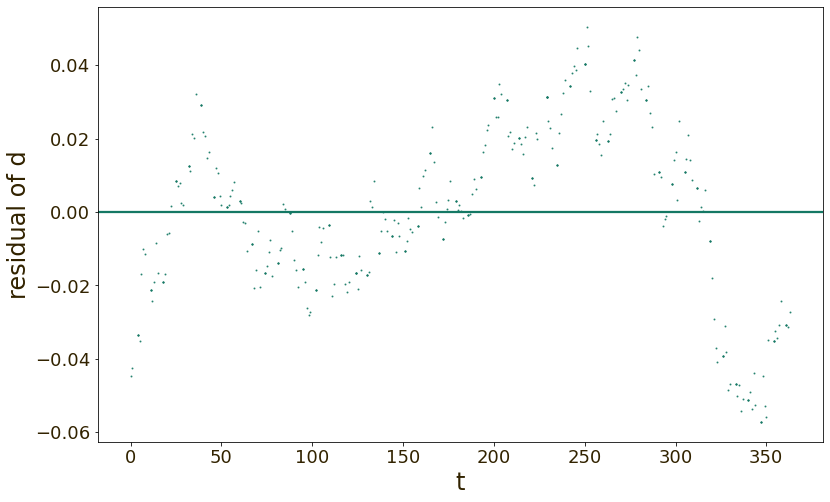

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
plt.xticks(fontsize=18, color="#322300")
plt.yticks(fontsize=18, color="#322300")
ax.set_xlabel("t", fontsize=24, color="#322300")
ax.set_ylabel("residual of d", fontsize=24, color="#322300")

# sbn.regplot(x=t_dat_stable, y=d_dat_stable, color='#00a0d2', order=1, \
#             scatter_kws={'s':1}, ci=None, truncate=False)

sbn.regplot(x=t_dat_stable, y=residual, color='#147864', order=1, \
            scatter_kws={'s':1}, ci=None, truncate=False)

<AxesSubplot:xlabel='Delta t', ylabel='norm. autocorr. of the residual'>

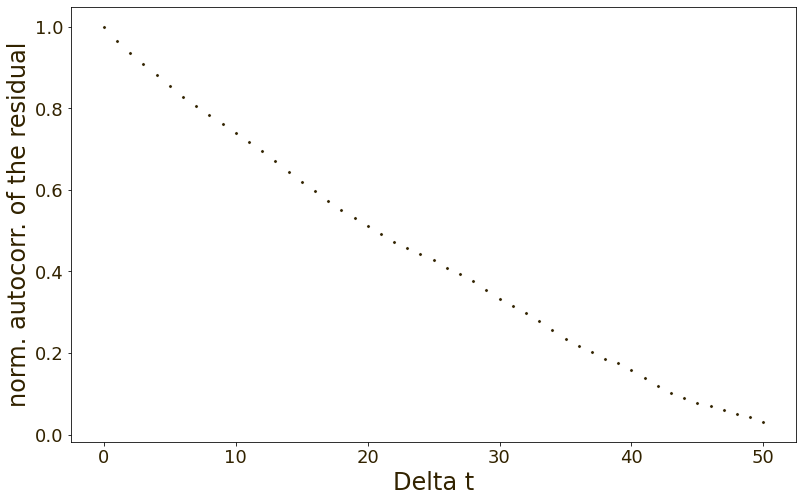

In [7]:
import statsmodels
import statsmodels.tsa
import statsmodels.tsa.stattools

aut = statsmodels.tsa.stattools.acf(residual, nlags=50)

fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
plt.xticks(fontsize=18, color="#322300")
plt.yticks(fontsize=18, color="#322300")
ax.set_xlabel("Delta t", fontsize=24, color="#322300")
ax.set_ylabel("norm. autocorr. of the residual", fontsize=24, color="#322300")

sbn.scatterplot(x=np.arange(0, aut.size, 1), y=aut, color="#322300", s=10)

<AxesSubplot:xlabel='Delta t', ylabel='ln rho(Delta t) for residual'>

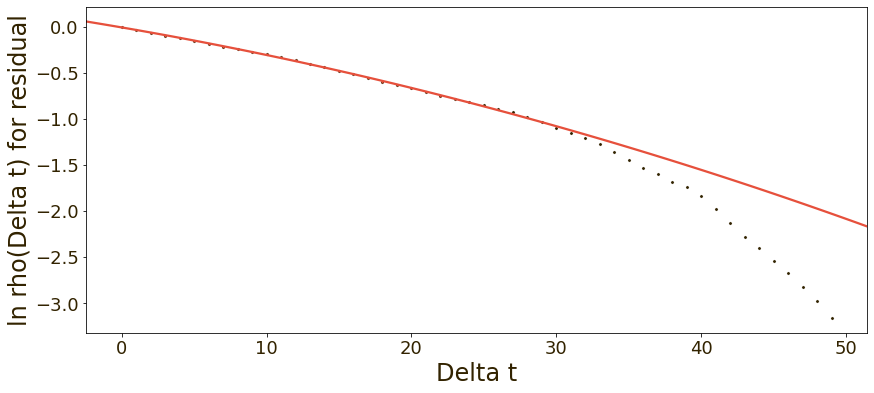

In [8]:
import math

t_log_out = np.arange(50)
log_aut = np.asarray([math.log(max(abs(x), 1.0e-04)) for x in aut[:50]])

fig, ax = plt.subplots()
fig.set_size_inches(14, 6)
plt.xticks(fontsize=18, color="#322300")
plt.yticks(fontsize=18, color="#322300")
ax.set_xlabel("Delta t", fontsize=24, color="#322300")
ax.set_ylabel("ln rho(Delta t) for residual", fontsize=24, color="#322300")

sbn.scatterplot(x=t_log_out, y=log_aut, color="#322300", s=10)

sbn.regplot(x=t_log_out[:25], y=log_aut[:25], color='#e6503c', order=2, \
            scatter_kws={'s':1}, ci=None, truncate=False)

In [9]:
import statsmodels.api as sm

lin_sqr_array = np.asarray([[t, t*t] for t in t_log_out[:25]])

compute_decorrelation_time = sm.OLS(log_aut[:25], lin_sqr_array).fit()

print("Statsmodels regression output:\n", compute_decorrelation_time.summary())

print("\nDecorrelation time:", -1/compute_decorrelation_time.params[0])

Statsmodels regression output:
                                  OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          5.657e+04
Date:                Wed, 23 Aug 2023   Prob (F-statistic):                    3.49e-43
Time:                        22:15:46   Log-Likelihood:                          90.152
No. Observations:                  25   AIC:                                     -176.3
Df Residuals:                      23   BIC:                                     -173.9
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---------

In [10]:
block_size = max(1, math.ceil(-3/compute_decorrelation_time.params[0]))
N_blocks = math.floor(t_dat_stable.size / block_size)

print("Evaluating", N_blocks, "blocks consisting of", block_size, "data points each.")

Evaluating 3 blocks consisting of 106 data points each.


In [11]:
sum_of_squares = 0.0
step_approximation = []

for i in range(N_blocks):
    this_block_sum = 0.0
    for j in range(block_size*i, block_size*(i+1)):
        this_block_sum += residual[j]
        
    this_block_average = this_block_sum / block_size
    sum_of_squares += this_block_average*this_block_average
    
    for k in range(block_size):
        step_approximation.append(this_block_average)

sigma_block_avg = math.sqrt(sum_of_squares / (N_blocks - 1))
print(np.asarray(step_approximation).size)
print(t_dat_stable.size)

318
364


<AxesSubplot:xlabel='t', ylabel='residual of d'>

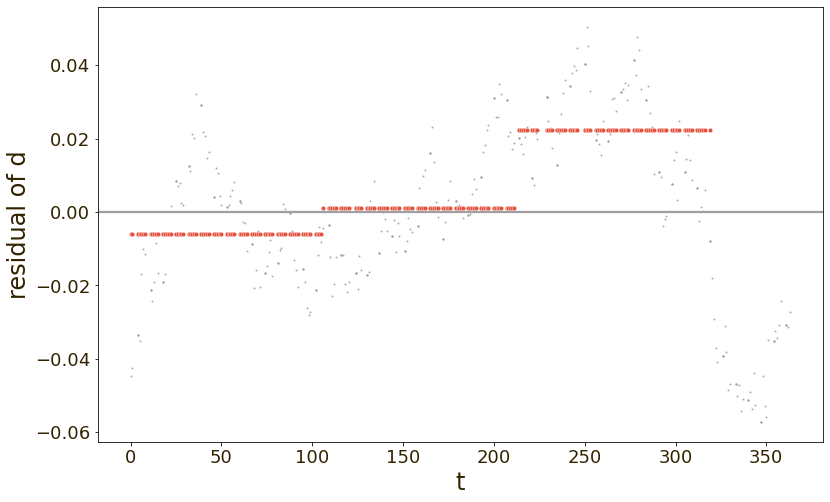

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
plt.xticks(fontsize=18, color="#322300")
plt.yticks(fontsize=18, color="#322300")
ax.set_xlabel("t", fontsize=24, color="#322300")
ax.set_ylabel("residual of d", fontsize=24, color="#322300")

step_array = np.asarray(step_approximation)
t_array = t_dat_stable[:step_array.size]

sbn.regplot(x=t_dat_stable, y=residual, color='#a0a0a0', order=1, \
            scatter_kws={'s':1}, ci=None, truncate=False)

sbn.scatterplot(x=t_array, y=step_array, color="#e6503c", s=20)

In [13]:
print("sigma of individual block-average data points:", sigma_block_avg)

# apply central limit theorem and divide by square root of number of blocks
sigma_whole = sigma_block_avg / math.sqrt(N_blocks)
print("sigma for whole series:", sigma_whole)

# uncertainty metric based on 2*sigma
print("\n*** 2*sigma uncertainty metric: ±", 2*sigma_whole, " ***", sep="")

sigma of individual block-average data points: 0.016436311328486528
sigma for whole series: 0.009489508769986194

*** 2*sigma uncertainty metric: ±0.018979017539972387 ***
